**EXPLORING THE DATA**

In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2020-06-01 12:23:42--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 2607:f8b0:400c:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   164MB/s    in 0.4s    

2020-06-01 12:23:42 (164 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os 
import zipfile

local_file = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_file, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


**TRAINING AND VALIDATION DATA SETA**

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# didrectory with training dataset
train_cat_dir = os.path.join(train_dir, 'cats')
train_dog_dir = os.path.join(train_dir, 'dogs')

# directory with validation dataset
validation_cat_dir = os.path.join(validation_dir, 'cats')
validation_dog_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
train_cat_fnames = os.listdir(train_cat_dir)
train_dog_fnames = os.listdir(train_dog_dir)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.864.jpg', 'cat.84.jpg', 'cat.746.jpg', 'cat.111.jpg', 'cat.210.jpg', 'cat.924.jpg', 'cat.820.jpg', 'cat.387.jpg', 'cat.573.jpg', 'cat.895.jpg']
['dog.666.jpg', 'dog.537.jpg', 'dog.833.jpg', 'dog.572.jpg', 'dog.907.jpg', 'dog.355.jpg', 'dog.827.jpg', 'dog.222.jpg', 'dog.234.jpg', 'dog.956.jpg']


In [ ]:
print('total cat images: ', len(os.listdir(train_cat_dir)))
print('total dog images: ', len(os.listdir(train_dog_dir)))
print('total validatioon images os cat: ', len(os.listdir(validation_cat_dir)))
print('total validation images of dog: ', len(os.listdir(validation_dog_dir)))

total cat images:  1000
total dog images:  1000
total validatioon images os cat:  500
total validation images of dog:  500


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#parameter of our graph ----> output images in 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0  # index for iterating over images

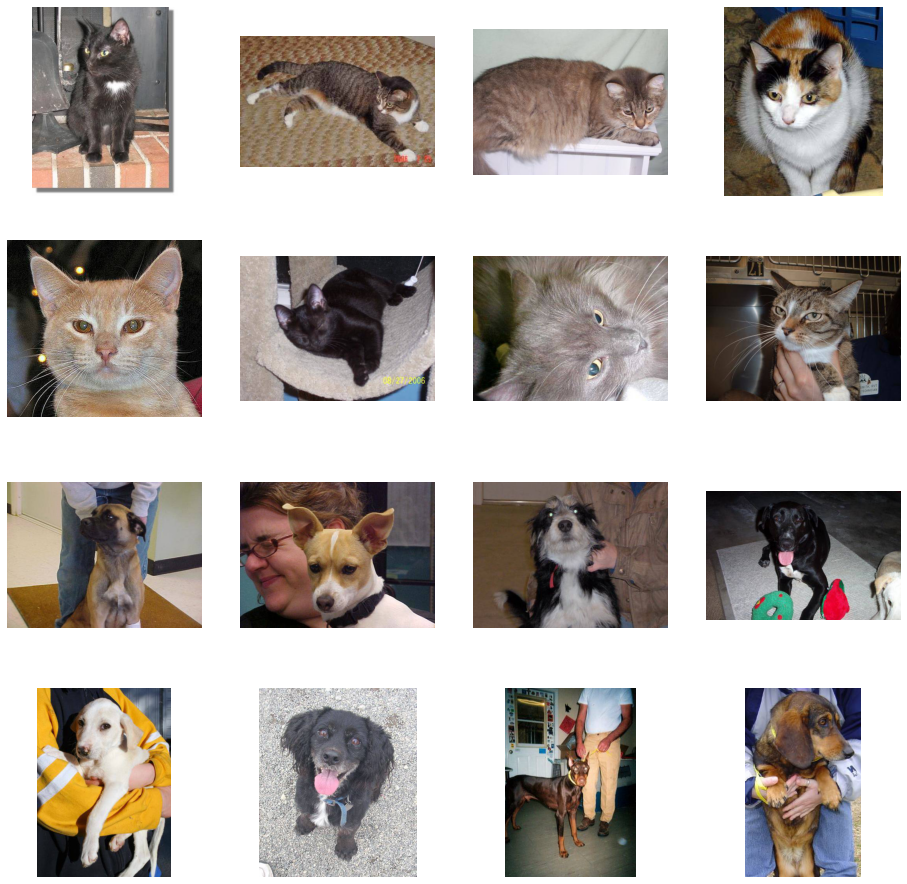

In [ ]:
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 8

next_cat_pix = [os.path.join(train_cat_dir, fnames) for fnames in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dog_dir, fnames) for fnames in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # plot subplot images
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('off')
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


**Building a Small Model from Scratch to Get to ~72% Accuracy**

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.Sequential([
                             # make desired of images in 150x150with 3 byte of color
                             tf.keras.layers.Conv2D(16, (3, 3), activation = tf.nn.relu, input_shape = [150, 150, 3]),
                             tf.keras.layers.MaxPooling2D(2, 2),
                             tf.keras.layers.Conv2D(32, (3, 3), activation = tf.nn.relu),
                             tf.keras.layers.MaxPooling2D(2, 2),
                             tf.keras.layers.Conv2D(64, (3, 3), activation = tf.nn.relu),
                             tf.keras.layers.MaxPooling2D(2, 2),
                             
                             # flatten result to fed into DNN
                             tf.keras.layers.Flatten(),

                             # 512 hidden neuron layer  
                             tf.keras.layers.Dense(512, activation = tf.nn.relu),

                             # 1 output neuron, it contain 0-1 from 0 ---> class cat  1 ----> calsss dog
                             tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)            

**COMPILE**

In [ ]:
from tensorflow.keras.optimizers import RMSprop

In [ ]:
model.compile(
    optimizer = RMSprop(lr = 0.001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

**Data Preprocessing**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# all images are rescaled
train_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    batch_size = 20, 
                    class_mode = 'binary',
                    target_size = (150, 150)
)

# flow validation images in batch size of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    batch_size = 20,
    class_mode = 'binary',
    target_size = (150, 150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


**Training**

In [ ]:
hisory = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 100,
    epochs = 15,
    validation_steps = 50,
    verbose = 2
)

Epoch 1/15
100/100 - 57s - loss: 0.9910 - accuracy: 0.5360 - val_loss: 0.6858 - val_accuracy: 0.5360
Epoch 2/15
100/100 - 57s - loss: 0.6754 - accuracy: 0.6235 - val_loss: 0.6217 - val_accuracy: 0.6590
Epoch 3/15
100/100 - 56s - loss: 0.5850 - accuracy: 0.7095 - val_loss: 0.6203 - val_accuracy: 0.6870
Epoch 4/15
100/100 - 57s - loss: 0.4931 - accuracy: 0.7750 - val_loss: 0.6772 - val_accuracy: 0.6380
Epoch 5/15
100/100 - 56s - loss: 0.3995 - accuracy: 0.8270 - val_loss: 0.7867 - val_accuracy: 0.7060
Epoch 6/15
100/100 - 56s - loss: 0.2979 - accuracy: 0.8775 - val_loss: 0.7191 - val_accuracy: 0.7030
Epoch 7/15
100/100 - 56s - loss: 0.1895 - accuracy: 0.9170 - val_loss: 0.8732 - val_accuracy: 0.7220
Epoch 8/15
100/100 - 56s - loss: 0.1431 - accuracy: 0.9445 - val_loss: 1.0347 - val_accuracy: 0.6890
Epoch 9/15
100/100 - 56s - loss: 0.0853 - accuracy: 0.9700 - val_loss: 1.2688 - val_accuracy: 0.6990
Epoch 10/15
100/100 - 56s - loss: 0.0716 - accuracy: 0.9755 - val_loss: 1.4246 - val_accura

**Running the Model**

In [ ]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  # predicting image
  path='/content/' + fn
  img = image.load_img(path, target_size = (150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size = 10)
  print(classes[0])

  if classes[0] > 0:
    print(fn + 'is a dog')
  else:
    print(fn + 'is a cat')

 

Saving cat-2536662_640.jpg to cat-2536662_640 (3).jpg
[1.]
cat-2536662_640.jpgis a dog


**Visualizing Intermediate Representations**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


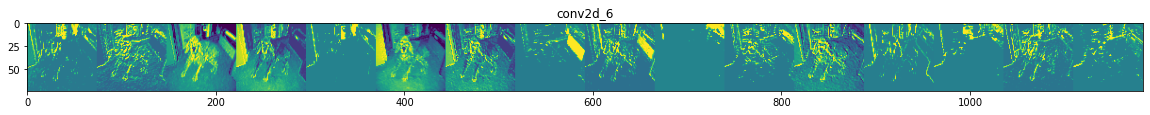

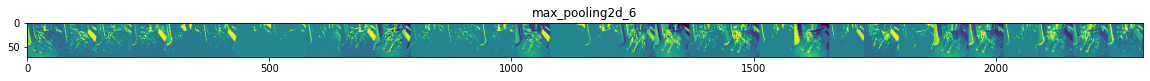

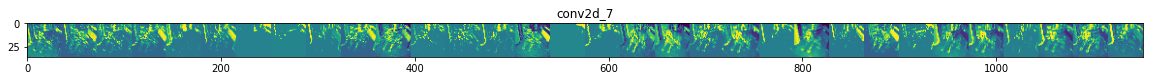

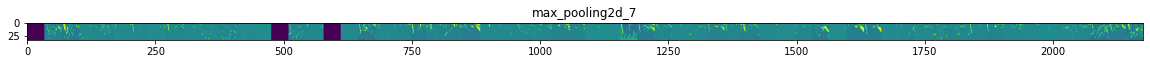

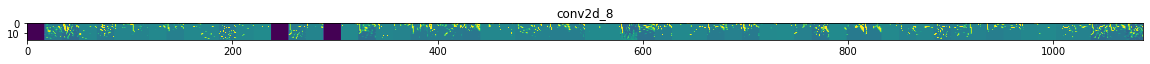

In [ ]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cat_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dog_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of sfeatures in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

**Evaluating Accuracy and Loss for the Model**

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

NameError: ignored